In [ ]:
# This notebook performs a statistical analysis on the learning rates between two groups of mice.
# Performs model fitting of individual mice, comparison of parameter, and statistical analysis
# between the groups to conclude differences and points of divergence in learning

In [ ]:
# run this on Colab
!rm -rf APE_paper/
!git clone https://github.com/HernandoMV/APE_paper.git
%pip install mouse-behavior-analysis-tools
%cd APE_paper/doc/figures_notebooks

In [1]:
%load_ext autoreload
%autoreload 2
import matplotlib.pylab as plt
import numpy as np
import seaborn as sns
import pandas as pd
from scipy import stats
from IPython.display import clear_output
from itertools import chain
from os.path import exists
import urllib.request

from mouse_behavior_analysis_tools.utils import custom_functions as cuf
from mouse_behavior_analysis_tools.utils.misc_utils import update_progress
from mouse_behavior_analysis_tools.plot import make_figures
from mouse_behavior_analysis_tools.model import behavior_model as bm
from mouse_behavior_analysis_tools.utils import model_utils

clear_output()

In [2]:
# This dataset has been pre-processed, but conditions have not been selected
# This preprocessing includes removal of disengaged trials and
# removal of the first 5 trials of each session

# download data from server
dataset_name = '6OHDA_dataframe.csv'
url = "https://zenodo.org/record/7261639/files/" + dataset_name
dataset_path = '../../data/' + dataset_name
# download if data is not there
if not exists(dataset_path):
    print('Downloading data...')
    urllib.request.urlretrieve(url, dataset_path)
else:
    print('Data already in directory')
# load
df_to_plot = pd.read_csv(dataset_path, index_col=0)

In [ ]:
# load the image data
image_dataset_name = '6OHDA_image-data.csv'
url = "https://zenodo.org/record/7261639/files/" + image_dataset_name
image_dataset_path = '../../data/' + image_dataset_name
# download if data is not there
if not exists(dataset_path):
    print('Downloading data...')
    urllib.request.urlretrieve(url, image_dataset_path)
else:
    print('Data already in directory')
# load
iar = pd.read_csv(image_dataset_path, index_col=0)

In [ ]:
# parameters for the plotting
hue_order = ['CortexBuffer', '6OHDAtail']
color_palette = [(0.24715576, 0.49918708, 0.57655991),
             (0.72162039, 0.3669119 , 0.22526315)]

sns.set_palette(color_palette)

In [3]:
# maximum number of trials performed per mouse in the dataset:
df_to_plot.groupby(['AnimalID', 'ExperimentalGroup', 'Protocol']).max()['CumulativeTrialNumberByProtocol']

AnimalID  ExperimentalGroup  Protocol
C01       CortexBuffer       Auditory    4999.0
C02       CortexBuffer       Auditory    4999.0
C03       CortexBuffer       Auditory    4999.0
PV01      6OHDAtail          Auditory    4999.0
PV02      6OHDAtail          Auditory    4999.0
PV03      6OHDAtail          Auditory    4999.0
PV04      6OHDAtail          Auditory    4999.0
PV05      6OHDAtail          Auditory    4999.0
PV06      6OHDAtail          Auditory    4999.0
PV08      6OHDAtail          Auditory    4999.0
SomFlp04  CortexBuffer       Auditory    4953.0
SomFlp06  CortexBuffer       Auditory    4999.0
SomFlp07  6OHDAtail          Auditory    4999.0
SomFlp08  6OHDAtail          Auditory    4999.0
SomFlp09  6OHDAtail          Auditory    4999.0
Name: CumulativeTrialNumberByProtocol, dtype: float64

#### Performance by session and 200-sized bins 

In [4]:
# bin trials every 200
df_to_plot["TrialIndexBinned200"] = (df_to_plot.CumulativeTrialNumberByProtocol // 200) * 200 + 100

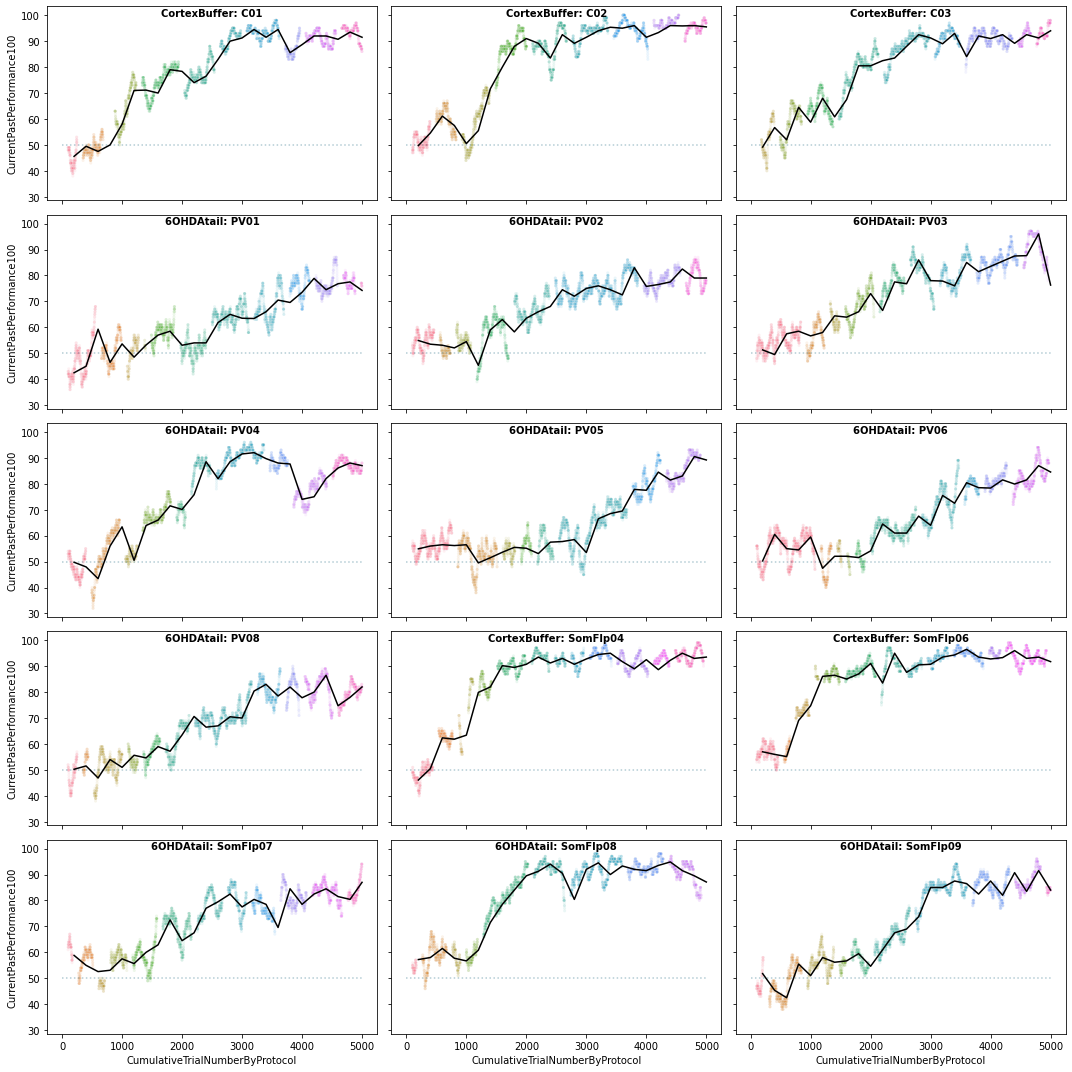

In [5]:
# Sanity check on the data to see that it looks good

fig = make_figures.make_figure_performance_trials_animals_bin(df_to_plot)
clear_output()
plt.show(fig)
# uncomment here to save the plot
# data_directory = ''
# plt.savefig(data_directory + 'Performance_by_session_individual_animals.pdf',
#             transparent=True, bbox_inches='tight')

Colored dots show the performance of the past 100 trials using an average running window. Each color represents a distinct session. The black line shows the performance value of the past 200 trials using trial bining.

#### Fit a sigmoid to every mouse to calculate and compare stages and learning rates

The sigmoid function is (perf_end - 0.5) / (1 + np.exp(-slope * (x - bias))) + 0.5

Data is scaled before the fitting and parameters are rescaled afterwards

The maximum performace possible is defined as the maximum of the median of the trials binned every 200 

In [6]:
#calculate the maximum performance for every mouse based on the trials binned every 200
df_bin200tr = df_to_plot.groupby(['AnimalID','ExperimentalGroup','TrialIndexBinned200','Protocol']).median().reset_index()
mouse_max_perf = df_bin200tr.groupby('AnimalID').max().reset_index()[['AnimalID', 'CurrentPastPerformance100']]

In [7]:
# fit the model
fit_df = bm.get_df_of_behavior_model_by_animal(df_to_plot, mouse_max_perf)

Progress: [####################] 100.0%


In [8]:
# find the steepest point of each slope (max of derivative)
der_max_dir = bm.get_steepest_point_of_slope(fit_df)

Progress: [####################] 100.0%


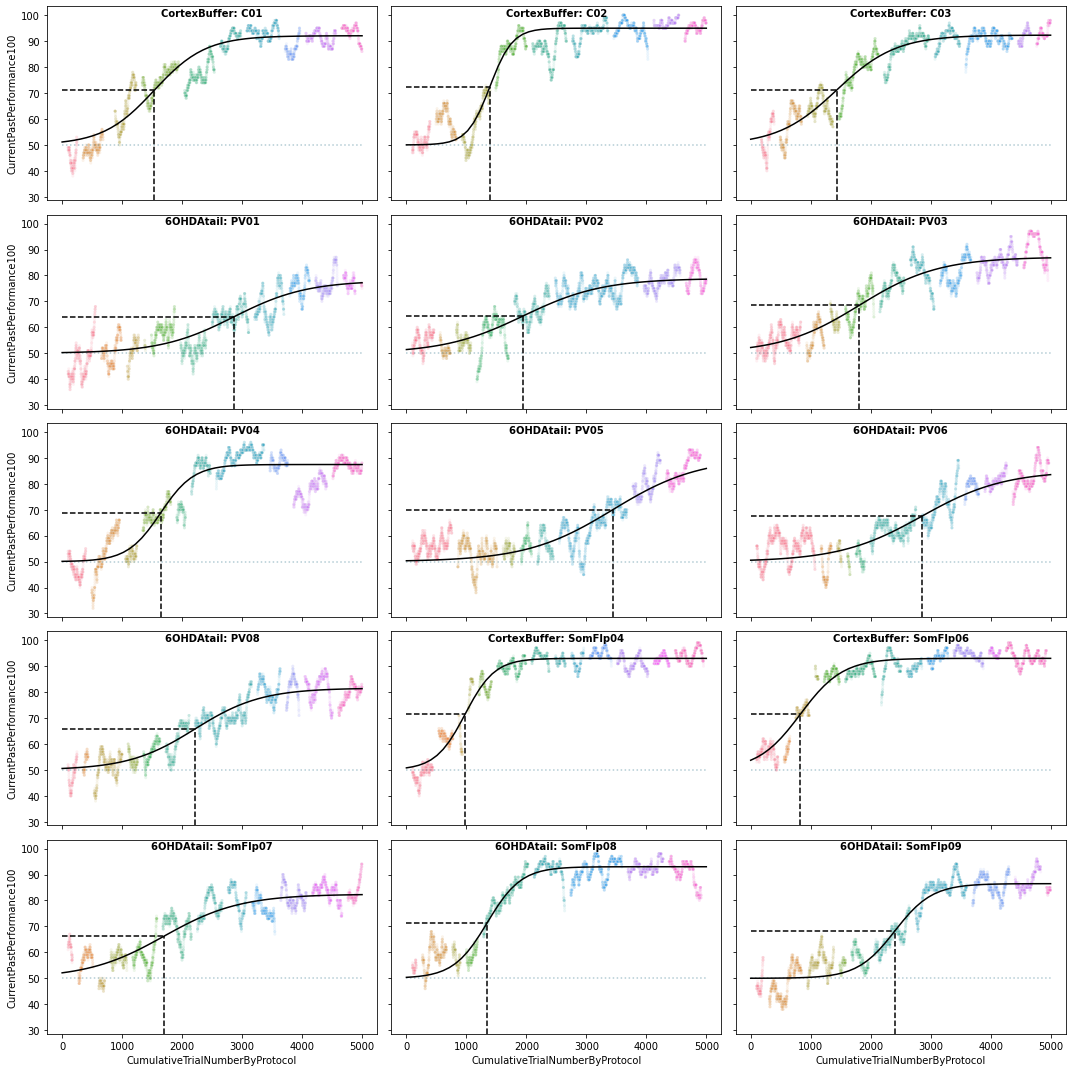

In [9]:
# plot the curves again pointing to the maximum
# sanity check to see that these scaled values recreate the curves
fig = make_figures.make_figure_performance_trials_animals_model(df_to_plot, fit_df, der_max_dir)
clear_output()
plt.show(fig)
# plt.savefig(data_directory + 'Sigmoid_fitting.pdf', transparent=True, bbox_inches='tight')


As a learning speed measure I use the point of the maximum learning rate, which is the maximum of the derivative of the fitting, which is also the middle point of the curve (in between 50% and maximum performance)
The bias indicates where this point lies in the x axis: at which trial number this point is reached

In [10]:
# add the maximum value of the derivative to the fit_df dataframe
for key, value in der_max_dir.items():
    fit_df.loc[fit_df.index[fit_df['AnimalID'] == key].tolist()[0], 'max_of_der'] = value[1]

### Merge with image data

In [11]:
merged_df = pd.merge(left=fit_df, right=iar, how='left', left_on='AnimalID', right_on='mouse id')[
    ['AnimalID',
     'maximum_performance',
     'bias',
     'ExperimentalGroup',
     'max_of_der',
     'median_performance_reached_in_last_ntrials',
     'n trials to criterion',
     'max performance reached',
     'ratio posterior/anterior']
]

##### The following cell creates **Figure 2 E** from the paper

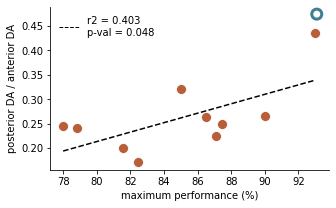

In [13]:
fig = make_figures.make_figure_6ohda_lesion_correlation(merged_df, color_palette)
plt.show(fig)
# plt.savefig(data_directory + '6ohda_lesion-correlation.pdf', transparent=True, bbox_inches='tight')

In [19]:
# There is one lesioned animal that is very close to the controls in terms of the lesioned area:
merged_df[['AnimalID', 'ExperimentalGroup', 'ratio posterior/anterior']]

,AnimalID,ExperimentalGroup,ratio posterior/anterior
0,C01,CortexBuffer,NaN
1,C02,CortexBuffer,NaN
2,C03,CortexBuffer,NaN
3,PV01,6OHDAtail,0.244704
4,PV02,6OHDAtail,0.240482
5,PV03,6OHDAtail,0.224340
6,PV04,6OHDAtail,0.248894
7,PV05,6OHDAtail,0.265733
8,PV06,6OHDAtail,0.320209
9,PV08,6OHDAtail,0.199283


In [25]:
# Remove this animal from the study
ans_to_remove = ['SomFlp08']
# ans_to_remove = []
df_to_plot = df_to_plot[~df_to_plot.AnimalID.isin(ans_to_remove)].copy()
fit_df = fit_df[~fit_df.AnimalID.isin(ans_to_remove)].copy()
print('Animals removed from the following analysis based on this:', ans_to_remove)

Animals removed from the following analysis based on this: ['SomFlp08']


### Differences of parameters between groups

In [26]:
# calculate significance
parameters_to_show = ['maximum_performance', 'max_of_der']
# define three levels of significance for the plotting
sig_levels = [0.05, 0.01, 0.001]
pvals = []
print('Kluskal-Wallis tests on the parameters')
for var in parameters_to_show:
    kt = stats.kruskal(fit_df[fit_df.ExperimentalGroup==hue_order[0]][var].dropna(),
                       fit_df[fit_df.ExperimentalGroup==hue_order[1]][var].dropna())
    print( var + ':\t\tpvalue: ' + str(kt.pvalue) )
    pvals.append(kt.pvalue)

Kluskal-Wallis tests on the parameters
maximum_performance:		pvalue: 0.0026997960632601883
max_of_der:		pvalue: 0.01963065725729074


##### The following cell creates **Figures 2 C, D** from the paper

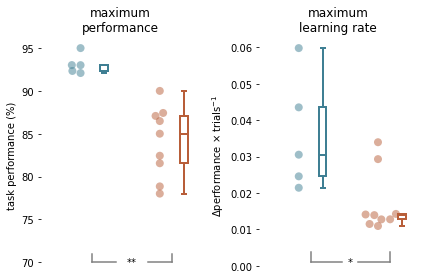

1 asterisks: pval < 0.05
2 asterisks: pval < 0.01
3 asterisks: pval < 0.001


In [27]:
# compare the parameters between groups
titles = ['maximum\nperformance', 'maximum\nlearning rate']
ylabs = ['task performance (%)', '\u0394performance \u00D7 trials$\mathregular{^{-1}}$']
yvals = [70, 0.001] # for the statistics

fig = make_figures.make_figure_learning_parameters_between_groups(fit_df, parameters_to_show,
                                                                  titles, ylabs,
                                                                  pvals, sig_levels,
                                                                  color_palette, hue_order, yvals)

# plt.savefig(data_directory + 'Parameters_group_comparison.pdf', transparent=True, bbox_inches='tight')
plt.show(fig)

for i,s in enumerate(sig_levels):
    print(i+1, 'asterisks: pval <', s)

### calculate the statistical differences of performances between groups at different points in learning

##### The following cell creates the first part of **Figure 2 B** from the paper

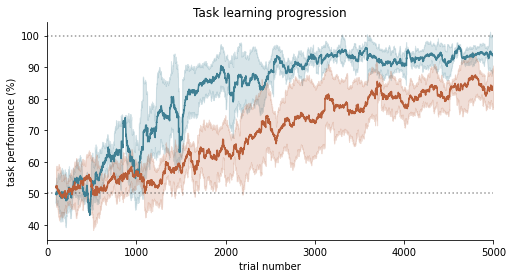

Shaded area indicates std, and performance is calculated using CurrentPastPerformance100


In [35]:
# Performance differences between groups across learning
col_to_plot = 'CurrentPastPerformance100'
fig1 = make_figures.make_figure_differences_performance_between_groups(df_to_plot, col_to_plot,
                                                                       hue_order, color_palette)

# plt.savefig(data_directory + 'Performance_between_groups.pdf', transparent=True, bbox_inches='tight')
plt.show(fig1)
print('Shaded area indicates std, and performance is calculated using', col_to_plot)

#### Calculate the significance by resampling: suffle the group labels multiple times and calculate the likelihood of observing this data
The shuffling respects the proportion of mice in every group.

References:

Supplementary figure 4 in here: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2562676/

See also methods here: https://www.biorxiv.org/content/10.1101/716274v3.full

In [36]:
# define a 100-trial window to bin the data
xbin = 100
df_to_plot["TrialIndexBinned"] = (df_to_plot.CumulativeTrialNumberByProtocol // xbin) * xbin + xbin / 2
print('Trials are binned in groups of', xbin)

Trials are binned in groups of 100


In [37]:
# groupby so each animal has a mean of the performance in each bin
df_bintr = df_to_plot.groupby(['AnimalID','ExperimentalGroup','TrialIndexBinned','Protocol']).mean().reset_index()

In [38]:
# create a scaled version of the performance
df_bintr['Performance'] = df_bintr.FirstPokeCorrect * 100

In [39]:
# calculate the differences of the real means using the binned data
real_data_pd = df_bintr[df_bintr.ExperimentalGroup == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'] -\
               df_bintr[df_bintr.ExperimentalGroup == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance']

In [40]:
# Select the amount of times to shuffle. Originally this is done 10,000 times
# use a smaller number to speed things up
nsh = 1000
print('Data is shuffled', nsh, 'times')

Data is shuffled 1000 times


In [41]:
# select the important columns to get the shuffled data
df_colsel = df_bintr[['AnimalID', 'ExperimentalGroup', 'TrialIndexBinned', 'Performance']].copy()
# get the shuffled data
shrdf = cuf.get_shuffled_means_difference_df(df_colsel, hue_order, nsh)

Progress: [####################] 100.0%


In [42]:
# calculate the confidence intervals for the shuffled data
pos_ci = shrdf.groupby('TrialIndexBinned').quantile(.95)
neg_ci = shrdf.groupby('TrialIndexBinned').quantile(.05)

##### The following cell creates the second part of **Figure 2 B** from the paper

This shows how likely is that each time point crosses 'random' line (point-base significance).

/tmp/ipykernel_70916/1597779116.py:6: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig2.show()


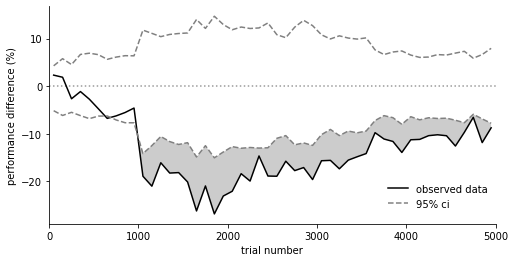

In [43]:
fig2 = make_figures.make_figure_differences_performance_significance(real_data_pd, pos_ci, neg_ci)
# plt.savefig(data_directory + 'Differences_of_means_significance_by_trial_bins.pdf',transparent=True, bbox_inches='tight')
plt.show(fig2)